This classfication model has about 84.66% accuracy, and the loss on the validation set is quite a bit lower than the training set. I'm still slightly unclear if this constitutes 'overfitting' and I'd love to experiment more with increased regularization (higher weight decay, less momentum) to see how that changes the loss difference. 


While working on this model I found this kaggle kernel on using the same dataset, which doesn't suffer from the same 'validation set loss much lower than training set loss':

https://www.kaggle.com/sharvari44/sentiment-analysis-using-lstm-ulmfit


However, my model doesn't seem to exhibit the behavior of overfitting as described here. https://forums.fast.ai/t/determining-when-you-are-overfitting-underfitting-or-just-right/7732/9?u=wigglepuff


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.text import *

In [3]:
#getting the fp to tweet data (I have a lot of extra files here due to many attempts in different ways)

path = Path('data/tweets 2')

path.mkdir(parents = True, exist_ok = True)
path.ls()

[PosixPath('data/tweets 2/tmp_lm'),
 PosixPath('data/tweets 2/lm_data.pkl'),
 PosixPath('data/tweets 2/tweets-temp'),
 PosixPath('data/tweets 2/test_data'),
 PosixPath('data/tweets 2/tmp_class'),
 PosixPath('data/tweets 2/tweets_valid.csv'),
 PosixPath('data/tweets 2/data_clas_export.pkl'),
 PosixPath('data/tweets 2/models'),
 PosixPath('data/tweets 2/.ipynb_checkpoints'),
 PosixPath('data/tweets 2/tweet_data'),
 PosixPath('data/tweets 2/train'),
 PosixPath('data/tweets 2/tweet_data.pkl'),
 PosixPath('data/tweets 2/temp'),
 PosixPath('data/tweets 2/tweet_together'),
 PosixPath('data/tweets 2/test')]

In [4]:
tweets = pd.read_csv(path/'tweets_valid.csv')

#made a new DF as calling 2 specific columns threw an error 

tweet2 = tweets[['airline_sentiment', 'text']]

tweet2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
train = tweet2[:int(len(tweet2)*.80)]
valid = tweet2[int(len(tweet2)*.20):]

#separated data into train, valid 80-20 ratio

In [6]:
tweets_lm = TextLMDataBunch.from_df(path, train, valid, 
                                    text_cols='text', label_cols='airline_sentiment')

#just used the same 80-20 ratio as I was going to use to assess the text classifier 

In [7]:
tweets_lm.show_batch()

#Data has been numericalized and tokenized behind the scenes, thanks to the TextLMDataBunch call. 

idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,. xxmaj got status on another airline ? xxmaj upgrade : http : / / t.co / xxunk ” xxunk ? xxunk xxbos @virginamerica trying to book a flight with you guys and your website wo n't let me ... about to lose my business xxbos @virginamerica you suck ! xxbos @virginamerica thanks ! xxbos @virginamerica xxmaj just dm'd . xxmaj same issue xxunk . xxbos @virginamerica xxmaj because we
2,atlantic ploughs a lone furrow in the # middleeast http : / / t.co / xxunk @thenationaluae xxbos @virginamerica xxmaj atlantic ploughs a lone furrow in the # middleeast http : / / t.co / xxunk @thenationaluae xxbos @virginamerica omg omg 😍 😍 nonstop xxmaj dallas to xxmaj austin on virgin ✨ 😱 ✈ ️ xxbos @virginamerica xxmaj your planes are really pretty . xxmaj just thought u should know
3,xxbos @united wo nt transfer flight ticket to xxunk an 11 yr old who 's active military mom had to have emergency brain surgery ? xxup wow ! ! xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup
4,"since xxmaj continental . xxmaj upgrade xxunk paying 3 times or more on top of purchase ticket . xxbos @united xxmaj deep xxmaj xxunk xxunk xxbos @united at its worse . xxmaj ca n't figure how to pack plane , screws up xxunk then claims no xxunk rooms in xxmaj san xxmaj fran for stranded pax . xxmaj way to go ! xxbos @united 4 passengers after a 2 hour"


In [9]:
tweets_lm.vocab.itos[:14]

#here's what the vocab looks like. the xx indicates an unknown / unrecognized character (could be emojis?)

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!']

**Transfer Learning**




In [19]:
lang_mod = language_model_learner(tweets_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


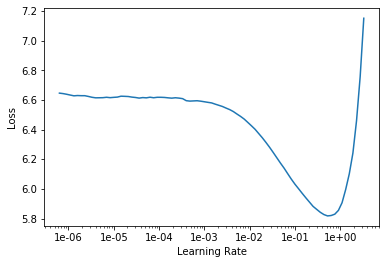

In [11]:
lang_mod.lr_find()
lang_mod.recorder.plot()

In [16]:
#lang_mod.fit_one_cycle(4, 2e-01)
#tried lr from .5 to .1, and a learning rate of .1 was the best.

epoch,train_loss,valid_loss,accuracy,time
0,4.794909,4.365984,0.235020,00:13
1,4.750334,4.260555,0.242669,00:13
2,4.453390,3.875092,0.266912,00:13
3,4.047036,3.712000,0.282422,00:13


In [18]:
#lang_mod.fit_one_cycle(4, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,4.701543,4.032880,0.254185,00:13
1,4.376852,3.845676,0.270225,00:13
2,4.039823,3.556688,0.298162,00:13
3,3.664048,3.441642,0.312730,00:13


In [20]:
lang_mod.fit_one_cycle(4, 1e-01, moms= .9)
#the one I decided to go with!

epoch,train_loss,valid_loss,accuracy,time
0,4.672909,4.033376,0.256669,00:12
1,4.362968,3.867460,0.271547,00:12
2,4.023876,3.539561,0.304164,00:13
3,3.651659,3.420306,0.313661,00:13


In [24]:
lang_mod.load('test');

The training loss and validation loss both decrease with each iteration. After looking around, the reason the validation loss is much lower is most likely due to the default implementation of dropout during training (regularization tactic), which does not happen during validation. 

I also reduced the default momentum slightly (.95 to .9), and it improved the model slightly. As my data is only 14000 rows, I'm happy to report more regularization indeed does help the model here. 

Edit: *I'd try decreasing the momentum even more*

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


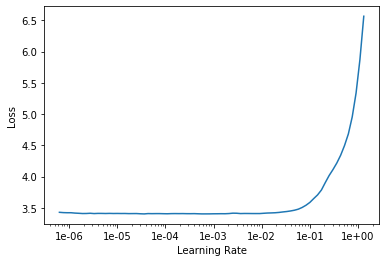

In [21]:
lang_mod.unfreeze()
lang_mod.lr_find(); lang_mod.recorder.plot()

In [25]:
lang_mod.fit_one_cycle(4, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.480266,3.362628,0.323804,00:16
1,3.427414,3.108306,0.362570,00:16
2,3.066788,2.692670,0.441242,00:16
3,2.510020,2.516665,0.484403,00:16


In [26]:
lang_mod.save('tuned_mod.pkl')
lang_mod.save_encoder('kaggle_encoder')

In [27]:
data_clas = TextClasDataBunch.from_df(path, train, valid, vocab=tweets_lm.train_ds.vocab, bs=32)
data_clas.save('data_clas_export.pkl')

In [38]:
class_mod = text_classifier_learner(data_clas, arch= AWD_LSTM, drop_mult=.4)
class_mod.load_encoder('kaggle_encoder')

In [29]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
"xxbos xxup @usairways xxup are xxup you xxup kidding xxup me ? ? xxmaj bad customer service , folks . xxmaj flew from xxup psp to xxup phx flight 2692 on 2 / 19 . ( cont ) http : / / t.co / xxunk",negative
xxbos xxup but @united just re - booked to xxup bos ; xxup xxunk ! ! now 3 hour bus to xxup xxunk home . xxmaj could have flown to xxup bdl & & back to xxup dc in same time . # unitedairlines,negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


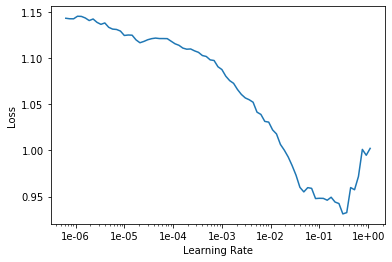

In [30]:
class_mod.lr_find(); class_mod.recorder.plot()

In [31]:
#class_mod.fit_one_cycle(1, 1e-02, wd= .1)


epoch,train_loss,valid_loss,accuracy,time
0,0.621391,0.516647,0.794740,00:12


Lower accuracy but lower loss is associated with higher variance: https://stats.stackexchange.com/questions/286222/low-loss-and-low-accuracy-what-is-the-reason


(The weight decay doesn't allow the model to learn as well, when compared to without wd. It's subtle, but I wanted to provide an explaination as I too, was curious).

In [39]:
class_mod.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.663351,0.523929,0.793460,00:12


In [40]:
class_mod.freeze_to(-2)

class_mod.fit_one_cycle(1, slice(1e-02/(2.6**4), 1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.592704,0.453267,0.833589,00:14


In [41]:
class_mod.save('classification_model.pkl')

In [47]:
class_mod.load('classification_model.pkl');

From here in Fast.ai, Jeremy uses 1e-5 as his learning rate (checking the notes, no explaination seems to be provided). I'll just use trusty *lr_find(); .recorder.plot()* again here. 

In [48]:
class_mod.unfreeze()
#class_mod.lr_find();class_mod.recorder.plot()
class_mod.fit_one_cycle(7, slice(1e-04/(2.6**4),1e-04),)

epoch,train_loss,valid_loss,accuracy,time
0,0.552146,0.441296,0.831455,00:24
1,0.527780,0.432785,0.837602,00:24
2,0.510092,0.422037,0.836236,00:24
3,0.539800,0.411365,0.839566,00:24
4,0.497054,0.408048,0.845543,00:24
5,0.502942,0.406627,0.846653,00:24
6,0.475184,0.404963,0.846568,00:24


In [49]:
class_mod.save('final_classification_model.pkl')

In [50]:
interp = ClassificationInterpretation.from_learner(class_mod)

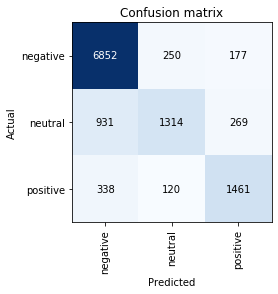

In [65]:
interp.plot_confusion_matrix()

**Outro:**

Here's some code for a even better language model, but I kept getting a size mismatch error when attempting to load the encoder into my classification model. I'd love to figure out why this model was better than the one that actually worked, and how I can get the encoder of this model working. 

In [18]:
train_1 = tweet2[:int(len(tweet2)*.90)]
valid_1 = tweet2[int(len(tweet2)*.10):]



tweets_lm_1 = TextLMDataBunch.from_df(path, train_1, valid_1, 
                                    text_cols='text', label_cols='airline_sentiment')


In [21]:

lang_mod_1 = language_model_learner(tweets_lm_1, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


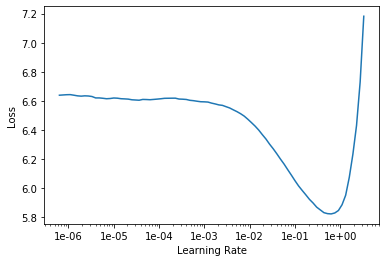

In [19]:
lang_mod_1.lr_find();lang_mod_1.recorder.plot()

In [22]:
lang_mod_1.fit_one_cycle(4, 2e-01, wd=.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.734754,4.291000,0.232354,00:29
1,4.699279,4.200869,0.246683,00:29
2,4.430247,3.761676,0.276497,00:29
3,3.974374,3.494644,0.300942,00:29


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


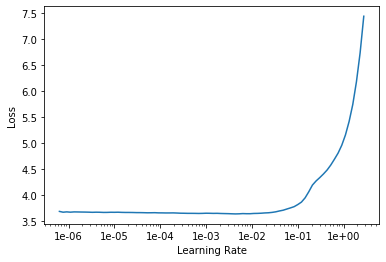

In [23]:
lang_mod_1.unfreeze()
lang_mod_1.lr_find(); lang_mod_1.recorder.plot()

In [24]:
lang_mod_1.fit_one_cycle(4, 2e-02, wd=.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.763940,3.479340,0.299355,00:36
1,3.744822,3.306697,0.325741,00:36
2,3.495496,2.908348,0.380670,00:36
3,2.974033,2.576910,0.437850,00:36


In [26]:
lang_mod_1.save('better_lm_model.pkl')
lang_mod_1.save_encoder('tuned_encoder')

In [41]:
data_clas_1 = TextClasDataBunch.from_df(path, train, valid, vocab=tweets_lm.vocab, bs=32)


In [43]:
data_clas_1.train_ds.vocab = tweets_lm.train_ds.vocab


class_mod_1 = text_classifier_learner(data_clas_1, arch= AWD_LSTM, drop_mult=.5)
class_mod_1.load_encoder('tuned_encoder')

RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	size mismatch for encoder.weight: copying a param with shape torch.Size([6336, 400]) from checkpoint, the shape in current model is torch.Size([5848, 400]).
	size mismatch for encoder_dp.emb.weight: copying a param with shape torch.Size([6336, 400]) from checkpoint, the shape in current model is torch.Size([5848, 400]).